In [10]:
import xarray as xr
from GadiClient import GadiClient
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime as dt
from itertools import product

In [2]:
experiment = "historical"
models = ["ACCESS1-3", "ACCESS1-0", "BNU-ESM", "CNRM-CM5", "GFDL-CM3",\
                    "GFDL-ESM2G", "GFDL-ESM2M", "IPSL-CM5A-LR", "IPSL-CM5A-MR",\
                    "MIROC5", "MRI-CGCM3", "bcc-csm1-1"]

hist_list = []
for m in models:
    hist_list.append(xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/clustering_"+m+"_"+experiment+"_1979_2005.nc"))

experiment = "rcp85"
rcp_list = []
for m in models:
    rcp_list.append(xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/clustering_"+m+"_"+experiment+"_2081_2100.nc"))


In [4]:
f = xr.concat(hist_list,dim="models")
r = xr.concat(rcp_list,dim="models")

In [54]:
r

<xarray.Dataset>
Dimensions:        (lat: 139, lon: 178, models: 12, time: 240)
Coordinates:
  * lat            (lat) float32 -10.0 -10.25 -10.5 ... -44.0 -44.25 -44.5
  * lon            (lon) float32 112.0 112.25 112.5 ... 155.75 156.0 156.25
Dimensions without coordinates: models, time
Data variables:
    cluster1       (models, lat, lon, time) float64 nan nan nan ... nan nan nan
    cluster2       (models, lat, lon, time) float64 nan nan nan ... nan nan nan
    cluster3       (models, lat, lon, time) float64 nan nan nan ... nan nan nan
    cluster1_bdsd  (models, lat, lon, time) float64 nan nan nan ... nan nan nan
    cluster2_bdsd  (models, lat, lon, time) float64 nan nan nan ... nan nan nan
    cluster3_bdsd  (models, lat, lon, time) float64 nan nan nan ... nan nan nan

In [56]:
def recon_time():
    start = dt.datetime(1979,1,1)
    out = []
    while start < dt.datetime(2006,1,1):
        out.append(start)
        if start.month < 12:
            start = start.replace(month=start.month+1)
        else:
            start = start.replace(year=start.year+1, month=1)
    return out

def recon_time2():
    start = dt.datetime(2081,1,1)
    out = []
    while start < dt.datetime(2101,1,1):
        out.append(start)
        if start.month < 12:
            start = start.replace(month=start.month+1)
        else:
            start = start.replace(year=start.year+1, month=1)
    return out

times = recon_time()
times2 = recon_time2()

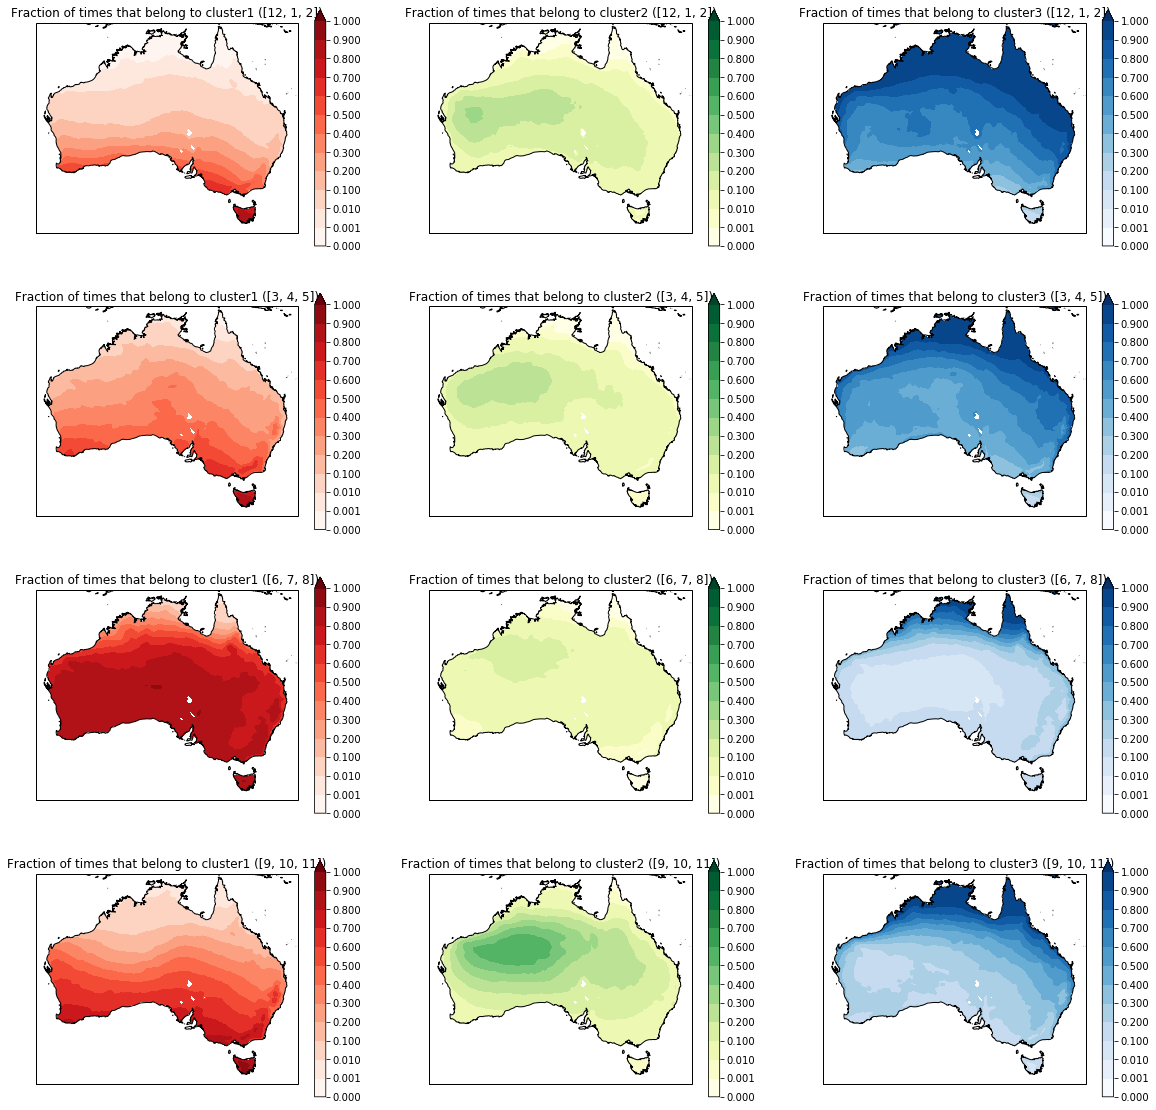

In [50]:
def plot_clim_cluster(da,times,months,ax):

    levs=[0,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

    cmaps = {"cluster1":plt.get_cmap("Reds"), "cluster2":plt.get_cmap("YlGn"), "cluster3":plt.get_cmap("Blues")}
    
    c=xr.plot.contourf(da.sel({"time":np.in1d([t.month for t in times],months)}).mean("time").median("models"), 
                       cmap=cmaps[da.name],levels=levs, ax=ax, extend="max",add_colorbar=False)
    ax.coastlines("10m")
    cb=plt.colorbar(c)
    cb.set_ticks(levs)
    plt.title("Fraction of times that belong to " + da.name + " (" + str(season) + ")")
    
    
from itertools import product

plt.figure(figsize=[20,20])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), (f.cluster1, f.cluster2, f.cluster3))
cnt=1
for season, da in iters:
    plot_clim_cluster(da, times, season, plt.subplot(4,3,cnt,projection=ccrs.PlateCarree()))
    cnt=cnt+1

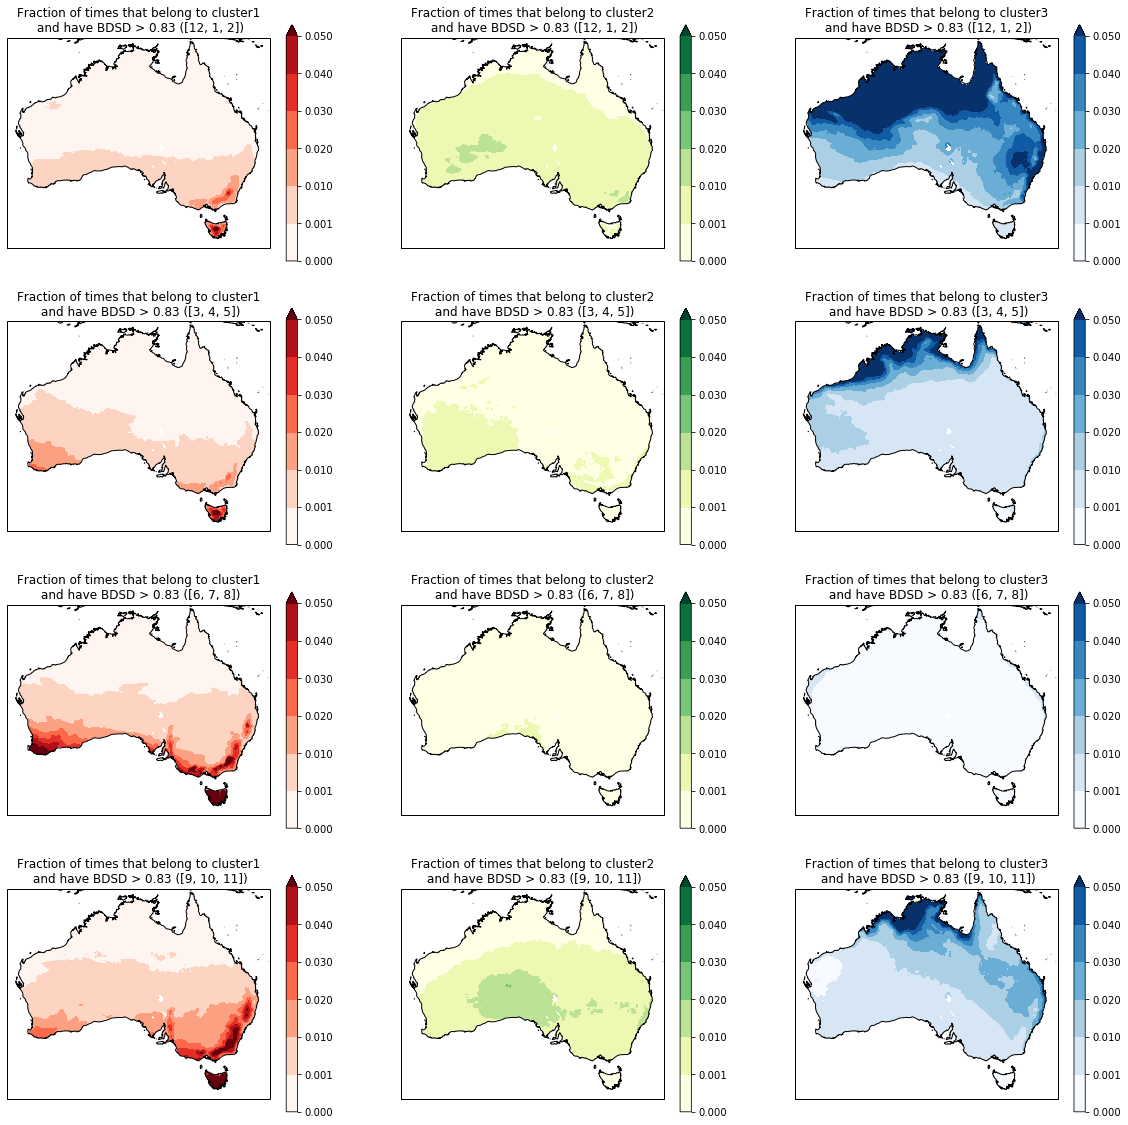

In [52]:
def plot_clim_bdsd(da,times,months,ax):

    levs=[0,0.001,0.01,0.02,0.03,0.04,0.05]
    
    cmaps = {"cluster1_bdsd":plt.get_cmap("Reds"), "cluster2_bdsd":plt.get_cmap("YlGn"), "cluster3_bdsd":plt.get_cmap("Blues")}
    
    c=xr.plot.contourf(da.sel({"time":np.in1d([t.month for t in times],months)}).mean("time").median("models"), 
                       cmap=cmaps[da.name],levels=levs, ax=ax, extend="max",add_colorbar=False)
    ax.coastlines("10m")
    cb=plt.colorbar(c)
    cb.set_ticks(levs)
    plt.title("Fraction of times that belong to "+ da.name.split("_")[0] +"\n and have BDSD > 0.83"+ " (" + str(season) + ")")
    


plt.figure(figsize=[20,20])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), (f.cluster1_bdsd, f.cluster2_bdsd, f.cluster3_bdsd))
cnt=1
for season, da in iters:
    plot_clim_bdsd(da, times, season, plt.subplot(4,3,cnt,projection=ccrs.PlateCarree()))
    cnt=cnt+1

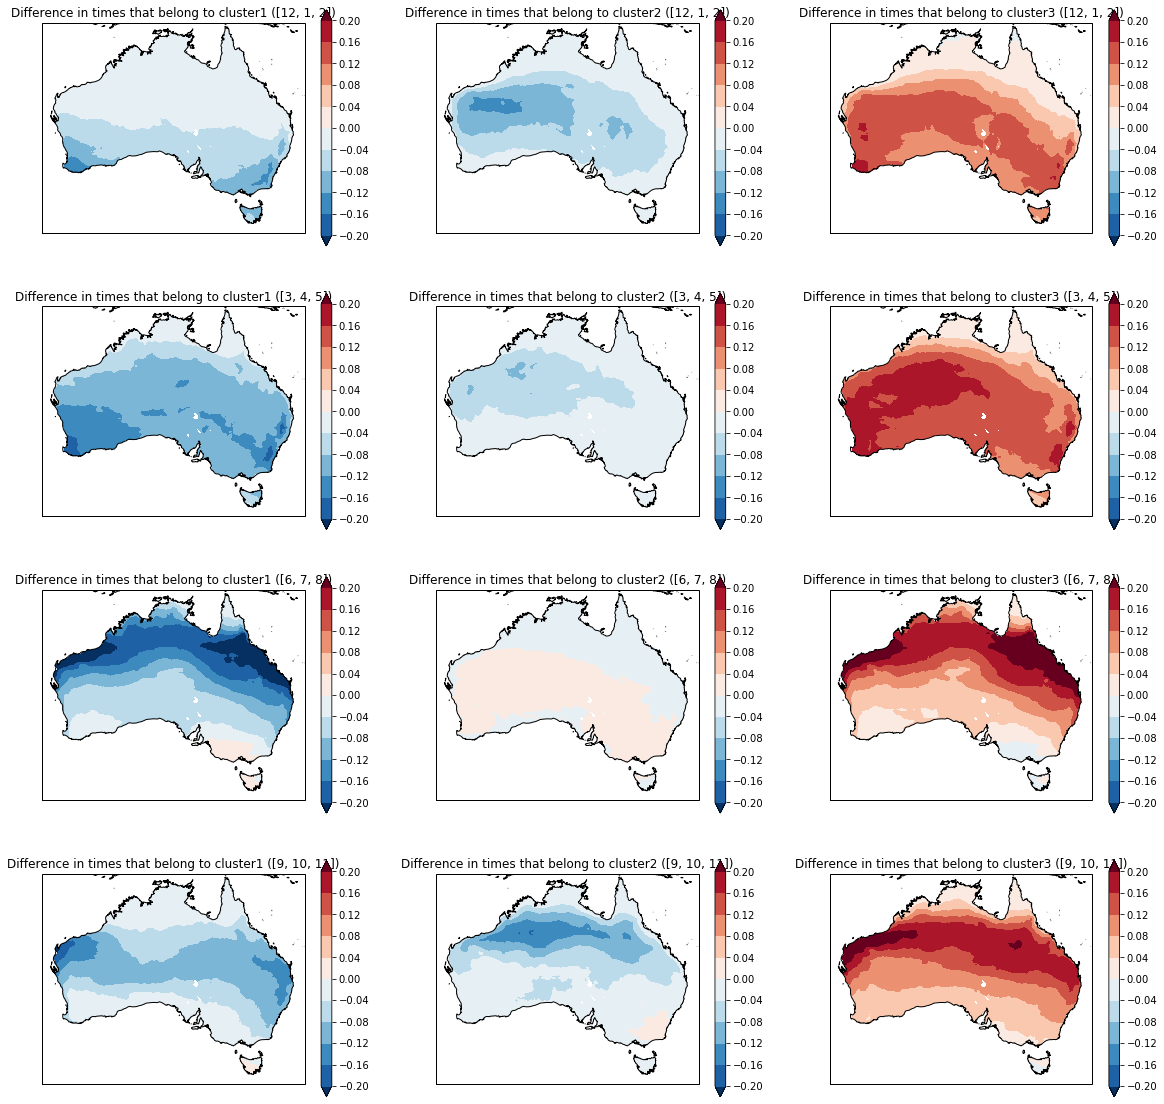

In [67]:
def plot_diff(da1,da2,times1,times2,months,ax):

    levs=np.linspace(-0.2,0.2,11)
    
    c=xr.plot.contourf((da2.sel({"time":np.in1d([t.month for t in times2],months)}).mean("time") - 
                       da1.sel({"time":np.in1d([t.month for t in times1],months)}).mean("time")).median("models"), 
                       cmap=plt.get_cmap("RdBu_r"),levels=levs, ax=ax, extend="both",add_colorbar=False)
    ax.coastlines("10m")
    cb=plt.colorbar(c)
    cb.set_ticks(levs)
    plt.title("Difference in times that belong to " + da1.name + " (" + str(season) + ")")

plt.figure(figsize=[20,20])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), zip((f.cluster1, f.cluster2, f.cluster3),(r.cluster1,r.cluster2,r.cluster3)))
cnt=1
for season, da in iters:
    plot_diff(da[0], da[1], times, times2, season, plt.subplot(4,3,cnt,projection=ccrs.PlateCarree()))
    cnt=cnt+1

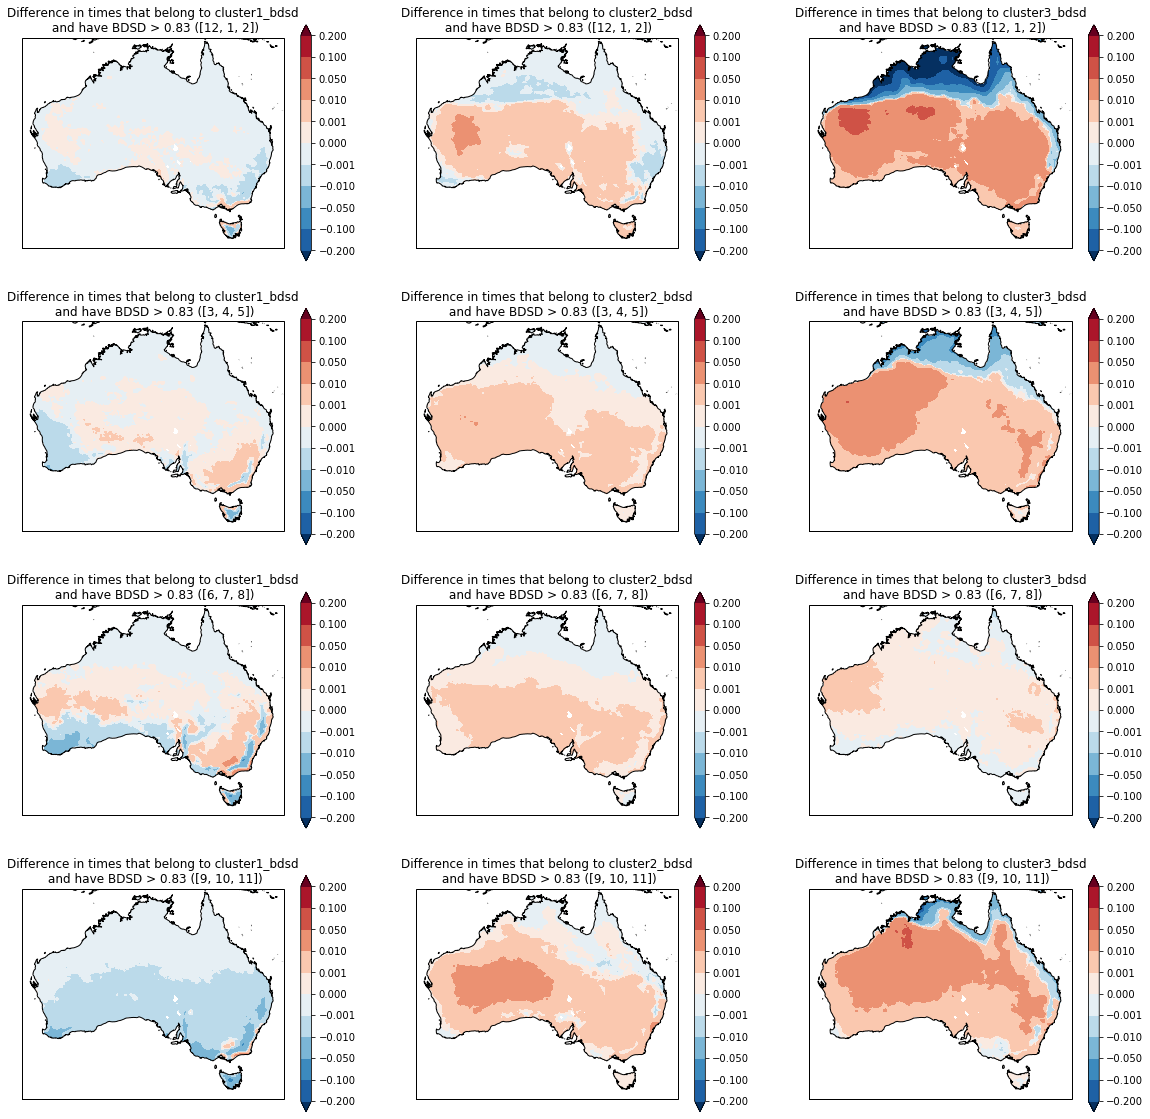

In [84]:
def plot_bdsd_diff(da1,da2,times1,times2,months,ax):

    levs=[-0.2,-0.1,-0.05,-0.01,-0.001,0,0.001,0.01,0.05,0.1,0.2]
    
    c=xr.plot.contourf((da2.sel({"time":np.in1d([t.month for t in times2],months)}).mean("time") - 
                       da1.sel({"time":np.in1d([t.month for t in times1],months)}).mean("time")).median("models"), 
                       cmap=plt.get_cmap("RdBu_r"),levels=levs, ax=ax, extend="both",add_colorbar=False)
    ax.coastlines("10m")
    cb=plt.colorbar(c)
    cb.set_ticks(levs)
    plt.title("Difference in times that belong to " + da1.name + "\n and have BDSD > 0.83 (" + str(season) + ")")

plt.figure(figsize=[20,20])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), zip((f.cluster1_bdsd, f.cluster2_bdsd, f.cluster3_bdsd),(r.cluster1_bdsd,r.cluster2_bdsd,r.cluster3_bdsd)))
cnt=1
for season, da in iters:
    plot_bdsd_diff(da[0], da[1], times, times2, season, plt.subplot(4,3,cnt,projection=ccrs.PlateCarree()))
    cnt=cnt+1

In [80]:
da[0]

<xarray.DataArray 'cluster3' (models: 12, lat: 139, lon: 178, time: 324)>
array([[[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]],


       ...,


       [[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]]])
Coordinates:
  * lat      (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -44.0 -44.25 -44.5
  * lon      (lon) float32 112.0 112.25 112.5 112.75 ... 155.75 156.0 156.25
Dimensions without coordinates: models, time

In [82]:
da[1]

<xarray.DataArray 'cluster3' (models: 12, lat: 139, lon: 178, time: 240)>
array([[[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]],


       ...,


       [[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]]])
Coordinates:
  * lat      (lat) float32 -10.0 -10.25 -10.5 -10.75 ... -44.0 -44.25 -44.5
  * lon      (lon) float32 112.0 112.25 112.5 112.75 ... 155.75 156.0 156.25
Dimensions without coordinates: models, time

In [ ]:
def plot_diff(da,times,months,ax):

    levs=[0,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

    cmaps = {"cluster1":plt.get_cmap("Reds"), "cluster2":plt.get_cmap("YlGn"), "cluster3":plt.get_cmap("Blues")}
    
    c=xr.plot.contourf(da.sel({"time":np.in1d([t.month for t in times],months)}).mean("time").median("models"), 
                       cmap=cmaps[da.name],levels=levs, ax=ax, extend="max",add_colorbar=False)
    ax.coastlines("10m")
    cb=plt.colorbar(c)
    cb.set_ticks(levs)
    plt.title("Fraction of times that belong to " + da.name + " (" + str(season) + ")")
    
    
from itertools import product

plt.figure(figsize=[20,20])
iters = product(([12,1,2],[3,4,5],[6,7,8],[9,10,11]), (f.cluster1, f.cluster2, f.cluster3))
cnt=1
for season, da in iters:
    plot_clim(da, times, season, plt.subplot(4,3,cnt,projection=ccrs.PlateCarree()))
    cnt=cnt+1

Text(0.5, 1.0, 'Fraction of times that belong to cluster 3\n and have BDSD > 0.83')

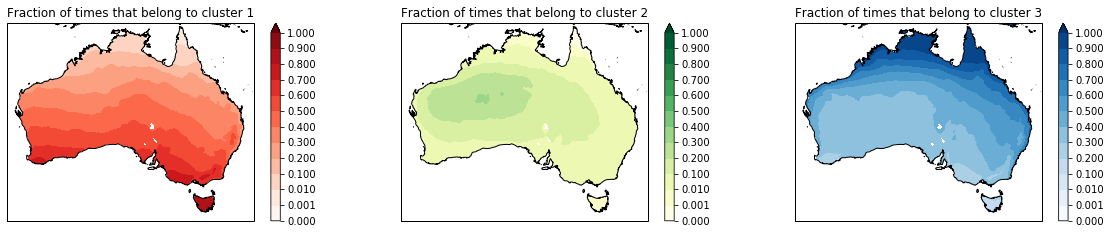

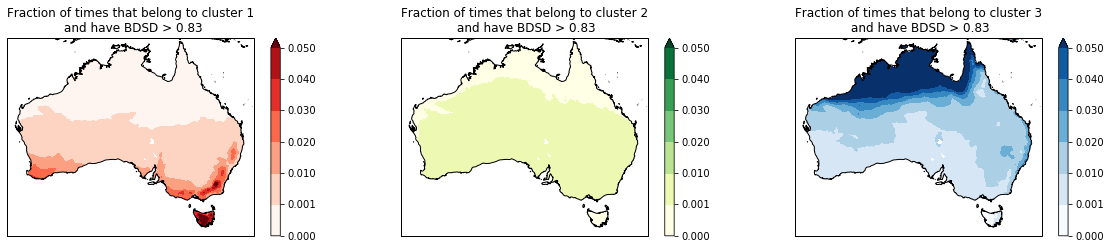

In [6]:
levs=[0,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

plt.figure(figsize=[20,8])
ax=plt.subplot(2,3,1,projection=ccrs.PlateCarree())
c=xr.plot.contourf(f.cluster1, cmap=plt.get_cmap("Reds"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 1")

ax=plt.subplot(2,3,2,projection=ccrs.PlateCarree())
c=xr.plot.contourf(f.cluster2, cmap=plt.get_cmap("YlGn"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 2")

ax=plt.subplot(2,3,3,projection=ccrs.PlateCarree())
c=xr.plot.contourf(f.cluster3, cmap=plt.get_cmap("Blues"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 3")




levs=[0,0.001,0.01,0.02,0.03,0.04,0.05]

plt.figure(figsize=[20,8])
ax=plt.subplot(2,3,1,projection=ccrs.PlateCarree())
c=xr.plot.contourf(f.cluster1_bdsd, cmap=plt.get_cmap("Reds"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 1\n and have BDSD > 0.83")

ax=plt.subplot(2,3,2,projection=ccrs.PlateCarree())
c=xr.plot.contourf(f.cluster2_bdsd, cmap=plt.get_cmap("YlGn"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 2\n and have BDSD > 0.83")

ax=plt.subplot(2,3,3,projection=ccrs.PlateCarree())
c=xr.plot.contourf(f.cluster3_bdsd, cmap=plt.get_cmap("Blues"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 3\n and have BDSD > 0.83")

Text(0.5, 1.0, 'Fraction of times that belong to cluster 3\n and have BDSD > 0.83')

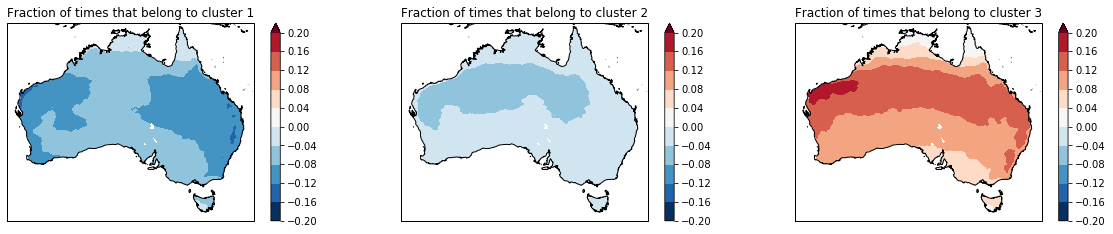

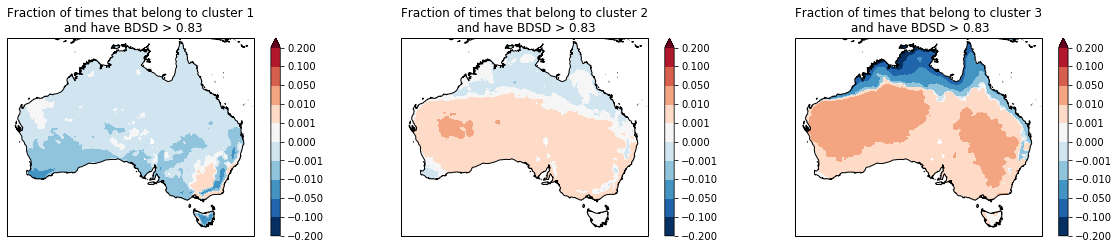

In [7]:
#levs=[0,0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
levs=np.linspace(-0.2,0.2,11)

plt.figure(figsize=[20,8])
ax=plt.subplot(2,3,1,projection=ccrs.PlateCarree())
c=xr.plot.contourf((r.cluster1 - f.cluster1), cmap=plt.get_cmap("RdBu_r"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 1")

ax=plt.subplot(2,3,2,projection=ccrs.PlateCarree())
c=xr.plot.contourf((r.cluster2 - f.cluster2), cmap=plt.get_cmap("RdBu_r"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 2")

ax=plt.subplot(2,3,3,projection=ccrs.PlateCarree())
c=xr.plot.contourf((r.cluster3 - f.cluster3), cmap=plt.get_cmap("RdBu_r"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 3")




levs=[-0.2,-0.1,-0.05,-0.01,-0.001,0,0.001,0.01,0.05,0.1,0.2]

plt.figure(figsize=[20,8])
ax=plt.subplot(2,3,1,projection=ccrs.PlateCarree())
c=xr.plot.contourf((r.cluster1_bdsd - f.cluster1_bdsd), cmap=plt.get_cmap("RdBu_r"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 1\n and have BDSD > 0.83")

ax=plt.subplot(2,3,2,projection=ccrs.PlateCarree())
c=xr.plot.contourf((r.cluster2_bdsd - f.cluster2_bdsd), cmap=plt.get_cmap("RdBu_r"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 2\n and have BDSD > 0.83")

ax=plt.subplot(2,3,3,projection=ccrs.PlateCarree())
c=xr.plot.contourf((r.cluster3_bdsd - f.cluster3_bdsd), cmap=plt.get_cmap("RdBu_r"),levels=levs, ax=ax, extend="max",add_colorbar=False)
ax.coastlines("10m")
cb=plt.colorbar(c)
cb.set_ticks(levs)
plt.title("Fraction of times that belong to cluster 3\n and have BDSD > 0.83")

In [26]:
xr.open_dataset("/g/data/eg3/ab4502/ExtremeWind/aus/regrid_1.5/clustering_"+m+"_"+experiment+"_1979_2005.nc")

<xarray.Dataset>
Dimensions:        (lat: 139, lon: 178, time: 324)
Coordinates:
  * lat            (lat) float32 -10.0 -10.25 -10.5 ... -44.0 -44.25 -44.5
  * lon            (lon) float32 112.0 112.25 112.5 ... 155.75 156.0 156.25
Dimensions without coordinates: time
Data variables:
    cluster1       (lat, lon, time) float64 ...
    cluster2       (lat, lon, time) float64 ...
    cluster3       (lat, lon, time) float64 ...
    cluster1_bdsd  (lat, lon, time) float64 ...
    cluster2_bdsd  (lat, lon, time) float64 ...
    cluster3_bdsd  (lat, lon, time) float64 ...